# Convergence Demo

In this notebook, we demonstrate a very quick and lightweight example that shows how to use attribution priors. It should take only a minute or two to run on CPU on any standard laptop. This notebook also demonstrates the benefit of _Expected Gradients_ as a feature attribution method for use with attribution priors. Since our expected gradients explainer is able to overcome saturation, it can fix the spurious correlation. Regularizing the input gradients or integrated gradients does not work as well

In [1]:
from attributionpriors.pytorch_ops import AttributionPriorExplainer
# to run IG examples, use the Pytorch Path Explainer from https://github.com/suinleelab/path_explain
from path_explain import PathExplainerTorch 

In [3]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import random


import os
from tqdm import *

import sys
sys.path.insert(0, '../')

np.random.seed(1017)
random.seed(1017)

import torch
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader

from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

In [4]:
device=torch.device('cuda')

### define data

Define a toy dataset with two features $x_1$ and $x_2$. In the training data, $x_1$ and $x_2$ are perfectly correlated. In the test data, they are uncorrelated. We want to model a third variable that is defined $y$ = $x_1$

In [5]:
class BinaryData(Dataset):
    
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        sample = self.X[index,:]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        if self.y is not None:
            return sample, self.y[index]
        else:
            return sample

In [6]:
a = torch.empty(1000,1).uniform_(0, 1)
x = torch.bernoulli(a)
x_train = torch.cat([x,x],axis=1)

a_test = torch.empty(1000,2).uniform_(0, 1)
x_test = torch.bernoulli(a_test)

y_train = x_train[:,0]
y_test = x_test[:,0]

In [7]:
train_dataset = BinaryData(x_train,y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True)

test_dataset = BinaryData(x_test,y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, drop_last=True)

### define a model

We can then initialize a neural network that might have been trained on this data, which depends on both features (since they are perfectly correlated in the training data, the model could depend on both equally).

In [8]:
##
## While this is obviously a trivial network, it makes training quick on CPU and helps illustrate the point
##

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
                    torch.nn.Linear(2, 1),
                    torch.nn.Sigmoid()
                )
    def forward(self, x):
        x = self.layers(x)
        return x

In [9]:
##
## Function to measure ground truth dependence of model on feature two vs. feature one
##

def calc_dependence(model):
    off_tensor_one = torch.tensor(np.concatenate([np.arange(0,1,0.01).reshape(-1,1),np.zeros(100).reshape(-1,1)],axis=1)).float().to(device)
    on_tensor_one = torch.tensor(np.concatenate([np.arange(0,1,0.01).reshape(-1,1),np.ones(100).reshape(-1,1)],axis=1)).float().to(device)
    
    off_tensor_zero = torch.tensor(np.concatenate([np.zeros(100).reshape(-1,1), np.arange(0,1,0.01).reshape(-1,1)],axis=1)).float().to(device)
    on_tensor_zero = torch.tensor(np.concatenate([np.ones(100).reshape(-1,1), np.arange(0,1,0.01).reshape(-1,1)],axis=1)).float().to(device)
    
    zero_dep = (model(on_tensor_zero)-model(off_tensor_zero)).mean().detach().cpu().numpy().reshape(-1)[0]
    one_dep = (model(on_tensor_one)-model(off_tensor_one)).mean().detach().cpu().numpy().reshape(-1)[0]
    
    return one_dep/zero_dep, zero_dep, one_dep

#### How many samples k are necessary for EG to regularize dependence on feature 2?

For 5 different numbers of $k$, measure convergence of objective over number of epochs

In [11]:
convergence_rate_list = []

for k in [1,2,3,4,5]:
    ##
    ## Initialize an MLP that depends equally on both features
    ##
    
    print('k =', k)

    model = MLP().to(device)
    with torch.no_grad():
        model.layers[0].weight[0, 0] = 10.
        model.layers[0].weight[0, 1] = 10.
        model.layers[0].bias[0] = -6.
    
    ##
    ## Define a background distribution (in this case the all-0s distribution will suffice)
    ## and initialize Expected Gradients explainer
    ##

    x_zeros = torch.zeros_like(x)
    background_dataset = BinaryData(x_zeros, y_train)

    APExp = AttributionPriorExplainer(background_dataset, 64, k=k)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    bce_term = torch.nn.BCELoss()
    
    mean_train_losses = []
    mean_valid_losses = []

    best_mtl = np.inf
    best_epoch = None
    
    convergence_list = []

    for epoch in range(200):
        model.train()

        train_losses = []
        valid_losses = []

        # train
        for i, (features, labels) in enumerate(train_loader):
            features, labels = features.float().to(device), labels.float().to(device)
            optimizer.zero_grad()

            outputs = model(features)

            ## get attributions
            eg = APExp.shap_values(model,features)
            ## get the average magnitude of the attributions
            ma_eg = eg.abs().mean(0)
            ## penalize the average magnitude of the attributions for feature $x_2$
            loss = bce_term(outputs,labels) + ma_eg[1].abs()

            loss.backward(retain_graph=True)
            optimizer.step()
            train_losses.append(loss.item())

        if np.mean(train_losses) < best_mtl:
            best_epoch = epoch
            best_mtl = np.mean(train_losses)

        mean_train_losses.append(np.mean(train_losses))
        convergence_list.append(calc_dependence(model)[0])
        
    convergence_rate_list.append(convergence_list)

k = 1


/home/ch6845/tools/miniconda3/envs/MarcoPolo/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


k = 2
k = 3
k = 4
k = 5


#### Repeat experiment but with the log prob. gradients, as proposed in Ross et al.

In [13]:
##
## add log prob gradients
bce_term = torch.nn.BCELoss()

model = MLP().to(device)
with torch.no_grad():
    model.layers[0].weight[0, 0] = 10.
    model.layers[0].weight[0, 1] = 10.
    model.layers[0].bias[0] = -6.

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
mse_term = torch.nn.MSELoss()

mean_train_losses = []
mean_valid_losses = []

best_mtl = np.inf
best_epoch = None

log_gradients_list = []

for epoch in range(200):
    model.train()

    train_losses = []
    valid_losses = []

    # train
    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.float().to(device), labels.float().to(device)
        features.requires_grad = True

        optimizer.zero_grad()
        
        outputs = model(features)
        new_outputs = torch.log(outputs)
        inp_grad = grad(outputs=new_outputs,
                    inputs=features,
                    grad_outputs=torch.ones_like(outputs),
                    create_graph=True)[0]
        ma_ig = inp_grad.abs().mean(0)
#         loss = ma_ig[1].abs()
        loss = bce_term(outputs,labels) + ma_ig[1].abs()
        loss.backward(retain_graph=True)
        optimizer.step()
        train_losses.append(loss.item())

    if np.mean(train_losses) < best_mtl:
        best_epoch = epoch
        best_mtl = np.mean(train_losses)

    mean_train_losses.append(np.mean(train_losses))
    log_gradients_list.append(calc_dependence(model)[0])

/home/ch6845/tools/miniconda3/envs/MarcoPolo/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [14]:
##
## add output gradients, modification of Ross et al. penalty 
bce_term = torch.nn.BCELoss()

model = MLP().to(device)
with torch.no_grad():
    model.layers[0].weight[0, 0] = 10.
    model.layers[0].weight[0, 1] = 10.
    model.layers[0].bias[0] = -6.

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
mse_term = torch.nn.MSELoss()

mean_train_losses = []
mean_valid_losses = []

best_mtl = np.inf
best_epoch = None

gradients_list = []

for epoch in range(200):
    model.train()

    train_losses = []
    valid_losses = []

    # train
    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.float().to(device), labels.float().to(device)
        features.requires_grad = True

        optimizer.zero_grad()
        
        outputs = model(features)
        inp_grad = grad(outputs=outputs,
                    inputs=features,
                    grad_outputs=torch.ones_like(outputs),
                    create_graph=True)[0]
        ma_ig = inp_grad.abs().mean(0)
        loss = bce_term(outputs,labels) + ma_ig[1].abs()
        loss.backward(retain_graph=True)
        optimizer.step()
        train_losses.append(loss.item())

    if np.mean(train_losses) < best_mtl:
        best_epoch = epoch
        best_mtl = np.mean(train_losses)

    mean_train_losses.append(np.mean(train_losses))
    gradients_list.append(calc_dependence(model)[0])

#### run with IG

In [15]:
model = MLP().to(device)
with torch.no_grad():
    model.layers[0].weight[0, 0] = 10.
    model.layers[0].weight[0, 1] = 10.
    model.layers[0].bias[0] = -6.

##
## Define a background distribution (in this case the all-0s distribution will suffice)
## and initialize Expected Gradients explainer
##

x_zeros = torch.zeros_like(x)
background_dataset = BinaryData(x_zeros,y_train)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
bce_term = torch.nn.BCELoss()

mean_train_losses = []
mean_valid_losses = []

best_mtl = np.inf
best_epoch = None

ig_2_list = []

for epoch in range(200):
    model.train()

    train_losses = []
    valid_losses = []

    # train
    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.float().to(device), labels.float().to(device)
        features.requires_grad = True
        optimizer.zero_grad()

        outputs = model(features)

        ## get attributions
        APExp = PathExplainerTorch(model)
        eg = APExp.attributions(features,torch.zeros_like(features)[0,:],use_expectation=False, num_samples = 2)
        ## get the average magnitude of the attributions
        ma_eg = eg.abs().mean(0)
        ## penalize the average magnitude of the attributions for feature $x_2$
        loss = bce_term(outputs,labels) + ma_eg[1].abs()
        loss.backward(retain_graph=True)
        optimizer.step()
        train_losses.append(loss.item())

    if np.mean(train_losses) < best_mtl:
        best_epoch = epoch
        best_mtl = np.mean(train_losses)

    mean_train_losses.append(np.mean(train_losses))
    ig_2_list.append(calc_dependence(model)[0])

In [ ]:
model = MLP().to(device)
with torch.no_grad():
    model.layers[0].weight[0, 0] = 10.
    model.layers[0].weight[0, 1] = 10.
    model.layers[0].bias[0] = -6.

x_zeros = torch.zeros_like(x)
background_dataset = BinaryData(x_zeros,y_train)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
bce_term = torch.nn.BCELoss()

mean_train_losses = []
mean_valid_losses = []

best_mtl = np.inf
best_epoch = None

ig_4_list = []

for epoch in range(200):
    model.train()

    train_losses = []
    valid_losses = []

    # train
    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.float().to(device), labels.float().to(device)
        features.requires_grad = True
        optimizer.zero_grad()

        outputs = model(features)

        ## get attributions
        APExp = PathExplainerTorch(model)
        eg = APExp.attributions(features,torch.zeros_like(features)[0,:],use_expectation=False, num_samples = 4)
        ## get the average magnitude of the attributions
        ma_eg = eg.abs().mean(0)
        ## penalize the average magnitude of the attributions for feature $x_2$
        loss = bce_term(outputs,labels) + ma_eg[1].abs()
        loss.backward(retain_graph=True)
        optimizer.step()
        train_losses.append(loss.item())

    if np.mean(train_losses) < best_mtl:
        best_epoch = epoch
        best_mtl = np.mean(train_losses)

    mean_train_losses.append(np.mean(train_losses))
    ig_4_list.append(calc_dependence(model)[0])

# plot number of epochs for convergence for each number of k for EG

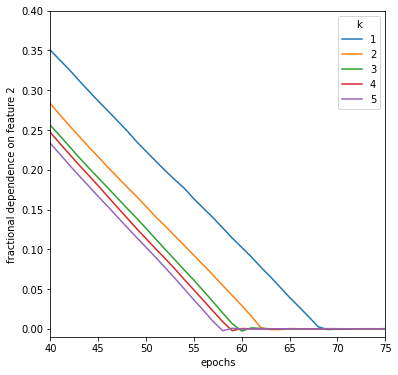

In [17]:
plt.figure(figsize=(6,6))
for k,curve in enumerate(convergence_rate_list):
    plt.plot(np.arange(len(curve)),curve,label=k+1)
plt.xlim([40,75])
plt.ylim([-0.01,0.4])
plt.legend(title='k')
plt.ylabel('fractional dependence on feature 2')
plt.xlabel('epochs')
plt.show()

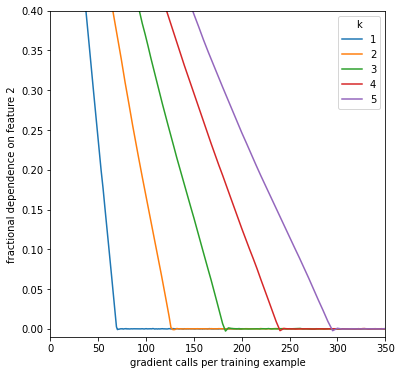

In [18]:
plt.figure(figsize=(6,6))
for k,curve in enumerate(convergence_rate_list):
    plt.plot((np.arange(len(curve))+1)*(k+1),curve,label=k+1)
# plt.xlim([40,75])
plt.xlim([0,350])
plt.ylim([-0.01,0.4])
plt.legend(title='k')
plt.ylabel('fractional dependence on feature 2')
plt.xlabel('gradient calls per training example')

plt.show()

# compare EG to other methods

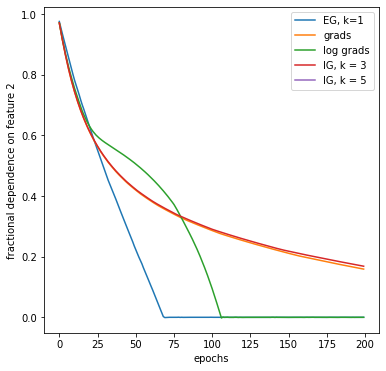

In [19]:
plt.figure(figsize=(6,6))

plt.plot(np.arange(len(convergence_rate_list[0])),convergence_rate_list[0],label='EG, k=1')
plt.plot(np.arange(len(gradients_list)),gradients_list,label='grads')
plt.plot(np.arange(len(log_gradients_list)),log_gradients_list,label='log grads')
plt.plot(np.arange(len(ig_2_list)),ig_2_list,label='IG, k = 3')
plt.plot(np.arange(len(ig_4_list)),ig_4_list,label='IG, k = 5')

plt.legend()
plt.ylabel('fractional dependence on feature 2')
plt.xlabel('epochs')
plt.show()